In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#add PyTorch and TorchVision (used for cropping etc.)
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

cwd = os.getcwd()

In [23]:
#load Accelerator data
#load Accelerator data

import yaml

d = yaml.safe_load(open('/home/sanjeev/GPT/simulation_2023-08-09_14-26-39/dump.yaml'))
data = pd.DataFrame(d['data'])
data.index = list(map(int, data.index))
data.sort_index(inplace=True)
len(data)


data['bunch_length'] = data['bunch_length']*1e-12




print(len(data))
data.head()
df = data

800


In [24]:
""" 
#-------------
features = ['sol_var','Gun_phase']
targets = ['Emit_X', 'Emit_y', 'Emit_mean', 'Energy', 'SigX', 'SigY', 'Bunch_length', 'Num_Particles'] """

# Define the features and targets
features = ['sol_var','gun_phase','bunch_charge','laser_pulse_length','QUAD:IN10:361:BCTRL','QUAD:IN10:371:BCTRL','QUAD:IN10:425:BCTRL','QUAD:IN10:441:BCTRL','QUAD:IN10:511:BCTRL','QUAD:IN10:525:BCTRL']
targets = ['emit_mean','bunch_length']


learning_rate = 0.1
momentum = 0.5
log_interval = 10

n_train = 700
n_test = 100
batch_size = 50

#create test and train datasets
train_data = torch.utils.data.TensorDataset(torch.tensor(df.head(n_train)[features].values).float(),
                                            torch.tensor(df.head(n_train)[targets].values).float())

test_data = torch.utils.data.TensorDataset(torch.tensor(df.tail(n_test)[features].values).float(),
                                           torch.tensor(df.tail(n_test)[targets].values).float())

awa_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
awa_test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


examples = enumerate(awa_train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(batch_idx)


torch.Size([50, 10])
0


Train Epoch: 0 [0/700 (0%)]	Loss: 0.062912
Train Epoch: 0 [500/700 (71%)]	Loss: 0.000033
Train Epoch: 1 [0/700 (0%)]	Loss: 0.000003
Train Epoch: 1 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 2 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 2 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 3 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 3 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 4 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 4 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 5 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 5 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 6 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 6 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 7 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 7 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 8 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 8 [500/700 (71%)]	Loss: 0.000000
Train Epoch: 9 [0/700 (0%)]	Loss: 0.000000
Train Epoch: 9 [500/700 (71%)]	Loss: 0.000000


/home/sanjeev/miniconda3/envs/ML/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


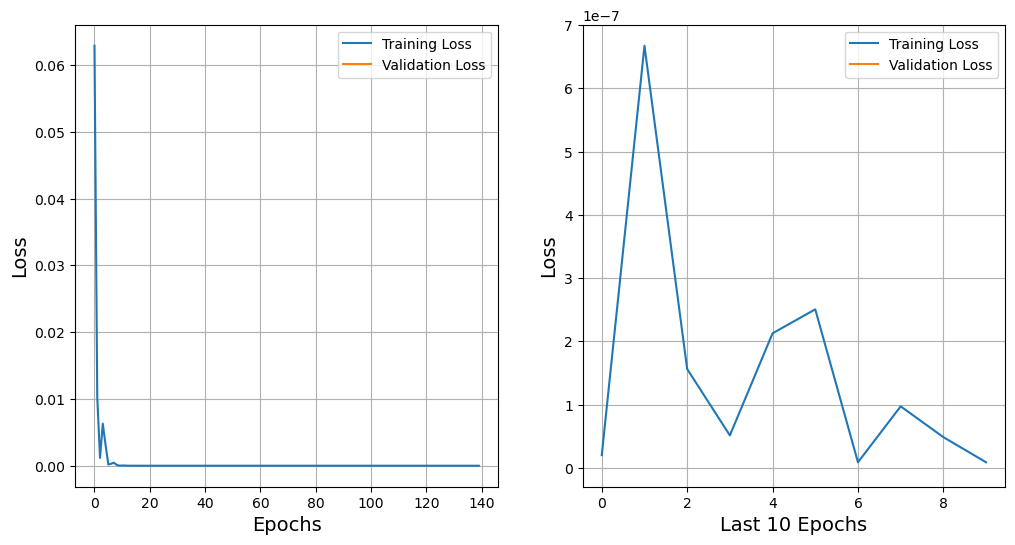

In [25]:
class AWANN(nn.Module):
    def __init__(self):
        super(AWANN, self).__init__()

        hidden_size = 20
        self.linear1 = nn.Linear(len(features), hidden_size)
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.linear4 = nn.Linear(hidden_size, len(targets))

    def forward(self, x):
        # propagate through model
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        x = self.linear4(x)
        
        return x
def train_model(model, epochs, train_loader, optimizer):
    
    train_losses = []
    train_counter = []
    
    #set network to training mode
    model.train()
    for epoch in range(epochs):
        #iterate through data batches
        for batch_idx, (data, target) in enumerate(train_loader):
            
            #reset gradients
            optimizer.zero_grad()

            #evaluate network with data
            output = model(data)

            #compute loss and derivative
            loss = F.mse_loss(output, target)
            loss.backward()

            #step optimizer
            optimizer.step()

           
            #print out results and save to file
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(model.state_dict(), cwd + '/results/model.pth')
            torch.save(optimizer.state_dict(), cwd + '/results/optimizer.pth')
        
    return train_losses, train_counter
def test_model(model, test_loader):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    return test_losses
awa_model = AWANN()



awa_optimizer = optim.SGD(awa_model.parameters(), lr=learning_rate,
                      momentum=momentum)

n_epochs = 10
train_losses,counter = train_model(awa_model, n_epochs, awa_train_loader, awa_optimizer)
test_losses = test_model(awa_model, awa_test_loader)
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()

# Plotting last 10 epochs in detail
plt.subplot(1, 2, 2)
plt.plot(train_losses[-10:], label='Training Loss')
plt.plot(test_losses[-10:], label='Validation Loss')
plt.xlabel('Last 10 Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()
plt.show()

      sol_var  gun_phase  bunch_charge  laser_pulse_length  \
1    0.961902   1.026856      1.271279                 0.0   
2   -1.840231  -0.799415      1.271279                 0.0   
3   -0.623297   2.229119      1.271279                 0.0   
4   -2.354267   2.308006     -0.488277                 0.0   
5   -1.023440   2.668373     -0.488277                 0.0   
..        ...        ...           ...                 ...   
796  0.291080  -0.795603     -0.488277                 0.0   
797  0.907263  -0.822662     -0.488277                 0.0   
798  0.292141  -0.827777     -0.488277                 0.0   
799 -0.289106  -0.801321     -0.488277                 0.0   
800  0.611773  -0.827735     -0.488277                 0.0   

     QUAD:IN10:361:BCTRL  QUAD:IN10:371:BCTRL  QUAD:IN10:425:BCTRL  \
1              -1.174802            -0.698650             0.687172   
2              -0.302368            -2.471269             1.388177   
3               1.410453            -2.222791

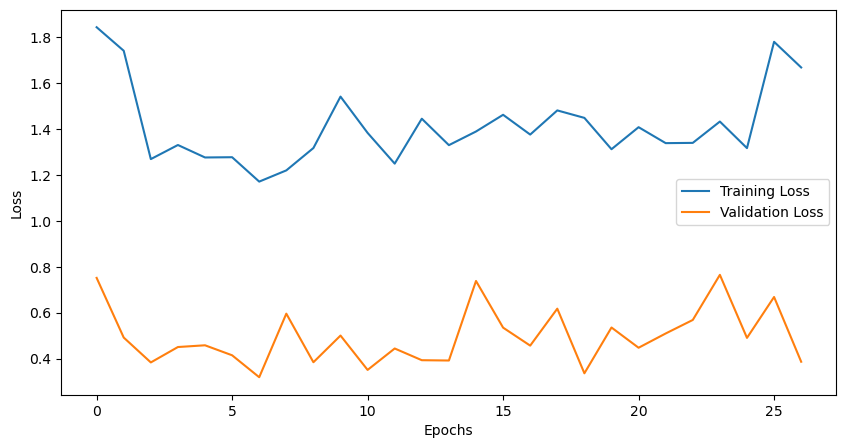

In [26]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# normalize the data
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
df[targets] = scaler.fit_transform(df[targets])
print(df[features])
# split the data into training and testing datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

# create PyTorch Datasets and DataLoaders
train_data = torch.utils.data.TensorDataset(torch.tensor(train_df[features].values).float(), torch.tensor(train_df[targets].values).float())
val_data = torch.utils.data.TensorDataset(torch.tensor(val_df[features].values).float(), torch.tensor(val_df[targets].values).float())
test_data = torch.utils.data.TensorDataset(torch.tensor(test_df[features].values).float(), torch.tensor(test_df[targets].values).float())

batch_size = 50
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# define the new model with dropout layers and larger hidden layer size
class AWANN(nn.Module):
    def __init__(self):
        super(AWANN, self).__init__()

        hidden_size = 50
        self.linear1 = nn.Linear(len(features), hidden_size)
        self.tanh1 = nn.Tanh()
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.tanh3 = nn.Tanh()
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(hidden_size, len(targets))

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.tanh3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        
        return x

# define the optimizer
learning_rate = 0.1
awa_model = AWANN()
awa_optimizer = optim.Adam(awa_model.parameters(), lr=learning_rate)

# define training and testing functions with early stopping
def train_model(model, train_loader, val_loader, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    early_stopping_counter = 0
    best_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = F.mse_loss(output, target)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}')

        if val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print('Early stopping...')
            break
    
    return train_losses, val_losses

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = F.mse_loss(output, target)
            test_loss += loss.item()
            
    test_loss /= len(test_loader)
    
    return test_loss

# start training the model
n_epochs = 100
patience = 20
train_losses, val_losses = train_model(awa_model, train_loader, val_loader, awa_optimizer, n_epochs, patience)

# test the model
test_loss = test_model(awa_model, test_loader)
print(f'Test Loss: {test_loss:.6f}')

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


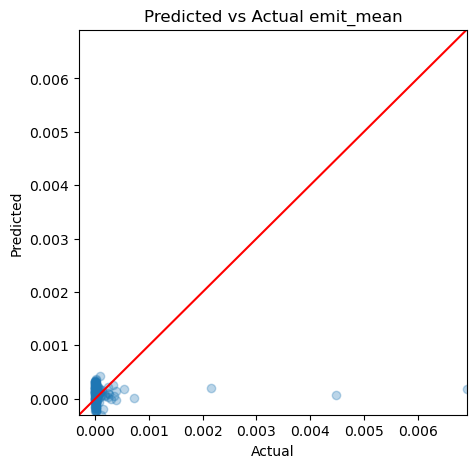

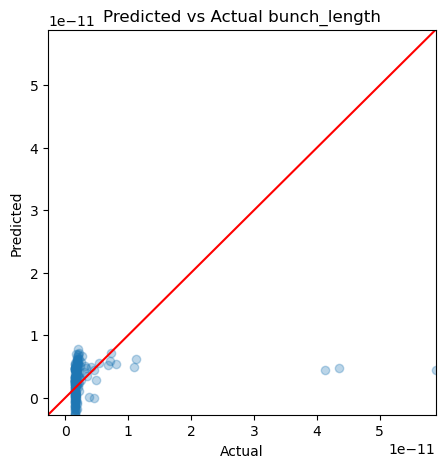

In [27]:
# calculate predictions
awa_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data, target in test_loader:
        output = awa_model(data)
        predictions.append(output.numpy())
        actuals.append(target.numpy())
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# inverse transform the data
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(actuals)

# create scatter plots
for i, target in enumerate(targets):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals[:, i], predictions[:, i], alpha=0.3)
    plt.title(f'Predicted vs Actual {target}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    max_val = max(actuals[:, i].max(), predictions[:, i].max())
    min_val = min(actuals[:, i].min(), predictions[:, i].min())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    plt.plot([min_val, max_val], [min_val, max_val], color='red')
    plt.show()


In [28]:
def test_model(model, test_loader):
    model.eval()
    mse_loss = 0
    mae_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            mse_loss += F.mse_loss(output, target).item()
            mae_loss += F.l1_loss(output, target).item()
            
    mse_loss /= len(test_loader)
    mae_loss /= len(test_loader)
    rmse_loss = np.sqrt(mse_loss)
    
    return mse_loss, rmse_loss, mae_loss


In [29]:
mse_loss, rmse_loss, mae_loss = test_model(awa_model, test_loader)
print(f'MSE Loss: {mse_loss:.6f}, RMSE Loss: {rmse_loss:.6f}, MAE Loss: {mae_loss:.6f}')


MSE Loss: 1.453657, RMSE Loss: 1.205677, MAE Loss: 0.452307


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


features = ['Sol_var','Gun_phase']
targets = ['Emit_X', 'Emit_y', 'Emit_mean', 'Energy', 'SigX', 'SigY', 'Bunch_length', 'Num_Particles']


# Splitting into training, validation and test sets
train_df, val_test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

n_train = len(train_df)
n_val = len(val_df)
n_test = len(test_df)
batch_size = 64
log_interval = 10

train_data = torch.utils.data.TensorDataset(torch.tensor(train_df[features].values).float(),
                                            torch.tensor(train_df[targets].values).float())
val_data = torch.utils.data.TensorDataset(torch.tensor(val_df[features].values).float(),
                                          torch.tensor(val_df[targets].values).float())
test_data = torch.utils.data.TensorDataset(torch.tensor(test_df[features].values).float(),
                                           torch.tensor(test_df[targets].values).float())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

class AWANN(nn.Module):
    def __init__(self):
        super(AWANN, self).__init__()

        hidden_size = 50
        self.net = nn.Sequential(
            nn.Linear(len(features), hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, len(targets))
        )

    def forward(self, x):
        return self.net(x)

def train_model(model, epochs, train_loader, val_loader, optimizer, scheduler):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
                
        scheduler.step()
        train_losses.append(train_loss/len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = F.mse_loss(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))
        
    return train_losses, val_losses

def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.mse_loss(output, target).item()
    return test_loss / len(test_loader)

model = AWANN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

n_epochs = 15
train_losses, val_losses = train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler)
test_loss = test_model(model, test_loader)

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()

# Plotting last 10 epochs in detail
plt.subplot(1, 2, 2)
plt.plot(train_losses[-10:], label='Training Loss')
plt.plot(val_losses[-10:], label='Validation Loss')
plt.xlabel('Last 10 Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [30]:
def plot_predictions(model, test_loader, feature_idx, feature_name):
    model.eval()
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predictions.extend(output[:, feature_idx].numpy())
            ground_truth.extend(target[:, feature_idx].numpy())

    # Converting lists to numpy arrays for easier manipulation
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    # Getting sorted indices based on the predictions
    sorted_indices = np.argsort(predictions)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(predictions[sorted_indices], label='Predictions')
    plt.plot(ground_truth[sorted_indices], label='Ground Truth')
    plt.xlabel('Test Samples Sorted by Predicted ' + feature_name, fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Plotting for 'Emit_X', 'Emit_y', and 'Bunch_length'
plot_predictions(model, test_loader, 0, 'Emit_X')
plot_predictions(model, test_loader, 1, 'Emit_y')
plot_predictions(model, test_loader, 6, 'Bunch_length')


NameError: name 'model' is not defined

/home/sanjeev/miniconda3/envs/ML/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


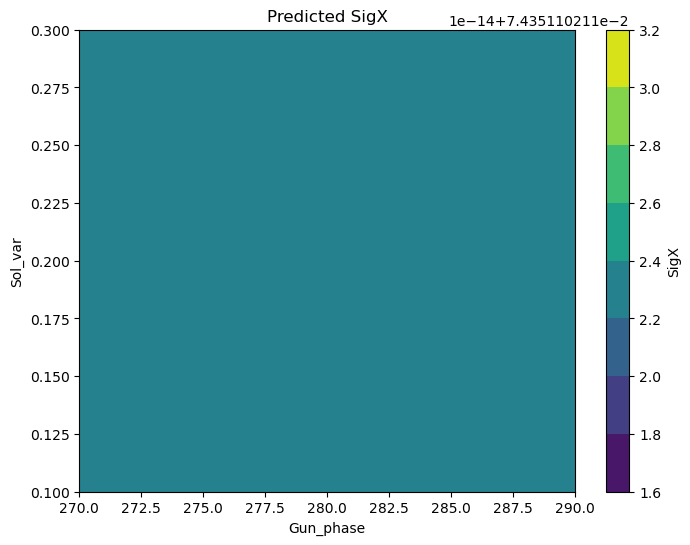

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a grid of 'Gun_phase' and 'Sol_var' values
gun_phase = np.linspace(270, 290, 100)
sol_var = np.linspace(0.1, 0.3, 100)
gun_phase_grid, sol_var_grid = np.meshgrid(gun_phase, sol_var)
input_grid = np.array([gun_phase_grid.ravel(), sol_var_grid.ravel()]).T

# Scale the inputs with the same scaler used before
input_grid_scaled = scaler.transform(input_grid)

# Pass the inputs through the model
model.eval()
with torch.no_grad():
    inputs = torch.tensor(input_grid_scaled).float()
    outputs = model(inputs).numpy()

# Choose which output to plot (e.g., the first one)
output_idx = 4

# Create the plot
plt.figure(figsize=(8, 6))
plt.contourf(gun_phase_grid, sol_var_grid, outputs[:, output_idx].reshape(gun_phase_grid.shape), cmap='viridis')
plt.colorbar(label=targets[output_idx])
plt.xlabel('Gun_phase')
plt.ylabel('Sol_var')
plt.title(f'Predicted {targets[output_idx]}')
plt.show()
